In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import jieba
from collections import Counter
import time
import math

In [2]:
path = '../data/cmn-eng/'

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

In [3]:
with open(path + 'cmn.txt') as f:
    lines = f.readlines()
    f.close()

In [4]:
def deal_en_sen( raw ):
    raw.strip()
    letters_only = re.sub("[^a-zA-Z]", " ", raw) 
    words = letters_only.lower().split()                             
    
    return(" ".join(words )) 

def deal_zh_sen( raw ):
    raw.strip()
    letters_only = re.sub("[^\u4e00-\u9fa5]", "", raw)                        
    
    return(letters_only) 

In [5]:
pairs = []
pair = []
for line in lines:
    nen = deal_en_sen(line.split('\t')[0])
    nzh = deal_zh_sen(line.split('\t')[1]) 
    pair.append(nen)
    pair.append(nzh)
    pairs.append(pair)
    pair = []

In [6]:
pairs[0:3]

[['hi', '嗨'], ['hi', '你好'], ['run', '你用跑的']]

In [7]:
en_counts = Counter()
zh_counts = Counter()

In [8]:
for i in range(len(pairs)):
    for word in str(pairs[i][0]).split(' '):
        en_counts[word] += 1
    for word in list(jieba.cut(pairs[i][1])):
        zh_counts[word] += 1

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.712 seconds.
Prefix dict has been built succesfully.


In [9]:
vocab_en = set(en_counts)
vocab_zh = set(zh_counts)

In [10]:
print(len(vocab_en))
print(len(vocab_zh))

5955
13018


In [11]:
word2index_en = {0: "SOS", 1: "EOS"}
for i, word in enumerate(vocab_en):
    word2index_en[word] = i + 2
    
word2index_zh = {0: "SOS", 1: "EOS"}
for i, word in enumerate(vocab_zh):
    word2index_zh[word] = i + 2

In [12]:
pairs_to_vec = []

for i in range(len(pairs)):
    pair_to_vec = []
    pair_en_to_vec = []
    pair_zh_to_vec = []
    for word in str(pairs[i][0]).split(' '):
        pair_en_to_vec.append(word2index_en[word])
    pair_en_to_vec.append(EOS_token)
    for word in list(jieba.cut(pairs[i][1])):
        pair_zh_to_vec.append(word2index_zh[word])
    pair_zh_to_vec.append(EOS_token)
    pair_to_vec.append(pair_en_to_vec)
    pair_to_vec.append(pair_zh_to_vec)    
    pairs_to_vec.append(pair_to_vec)

In [13]:
# 参数
USE_CUDA = True
MAX_LENGTH = 10
# 功能函数
def iterate_minibatches(data, batchsize, shuffle=False):
    length = len(data)
    if shuffle:
        indices = np.arange(length)
        np.random.shuffle(indices)
        
    for start_idx in range(0, length - batchsize + 1, batchsize):
        if shuffle:
            ran = indices[start_idx:start_idx + batchsize]
        else:
            ran = slice(start_idx, start_idx + batchsize)
        yield data[ran]
    
    
def gen_minibatch(data, batch_size, shuffle=True):
    for pair in iterate_minibatches(data, batch_size, shuffle):
        yield pair
        
def s(name, val):
    print(name + "'s size is {}".format(val))

In [14]:
# Model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, batch_size=1, bidirectional=False):
        super(EncoderRNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=False)

    def forward(self, sens_vec, hidden):
#         s("sens_vec", sens_vec.size())
#         print(sens_vec.is_cuda)
        embedded = self.embedding(sens_vec)
#         s("embedded", embedded.size())
#         s("hidden", hidden.size())
        output, hidden = self.gru(embedded, hidden)
#         s("output", output.size())
#         s("hidden", hidden.size())
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: 
            hidden = hidden.cuda()
        return hidden

# Attn 层
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        
    def forward(self, hidden, encoder_outputs):
# #         s("encoder_outputs", encoder_outputs.size())
        seq_len = encoder_outputs.size()[0]
        attn_energies = Variable(torch.zeros(seq_len))
        
        if USE_CUDA:
            attn_energies = attn_energies.cuda()
        
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i][0])

        return F.softmax(attn_energies)
    
    def score(self, hidden, encoder_output):
#         s("encoder_output", encoder_output.size())
        energy = self.attn(encoder_output)
        # 矩阵维度有些不理解
#         s("enenrgy", energy.view(-1).size())
#         s("hidden", hidden.squeeze(0).squeeze(0).size())
        
        energy = torch.dot(hidden.squeeze(0).squeeze(0), energy.view(-1))
#         print(energy)
#         s("new energy", energy.size())
        return energy
# 改进的解码层
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=.1):
        super(AttnDecoderRNN, self).__init__()
        # 定义参数
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # 定义层
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.attn = Attn(hidden_size)

    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
#         s("word_input_de", word_input.view(-1, 1).size())
        word_embedded = self.embedding(word_input.view(-1, 1))
#         s("word_embedded_de", word_embedded.size())
        
#         s("last_context", last_context.size())
        rnn_input = torch.cat((word_embedded, last_context), 2)
#         s("rnn_input", rnn_input.size())
#         s("last_hidden", last_hidden.size())
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
#         s("rnn_output", rnn_output.size())
#         print(rnn_output)
        attn_weights = self.attn(rnn_output, encoder_outputs)
#         print(attn_weights)
#         s("encoder_outputs", encoder_outputs.transpose(0, 1).size())
#         s("attn_weights", attn_weights.unsqueeze(0).unsqueeze(1).size())
        context = attn_weights.unsqueeze(0).unsqueeze(1).bmm(encoder_outputs.transpose(0, 1)) 
#         s("context", context.size())
#         print(self.out(torch.cat((rnn_output, context), 2)).squeeze(0))
        
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 2)).squeeze(0))
#         print(output)

        return output, context, hidden, attn_weights

In [15]:
teacher_forcing_ratio = 0.5
clip = 5.0
MAX_LENGTH = 10

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

#     print(target_variable)
    
    # Get size of input and target sentences
    input_length = input_variable.size()[0]
#     print("input's len is {}".format(input_length))
    target_length = target_variable.size()[0]
#     print("target's len is {}".format(target_length))
    
#     print(input_variable.is_cuda)

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
#     print(type(encoder_hidden))
#     print(type(input_variable))
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, 1, decoder.hidden_size))
#     s("decoder_input", decoder_input.size())
#     s("decoder_context", decoder_context.size())
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = np.random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
#             s("decoder_output", decoder_output.size())
#             s("target_variable", target_variable[di].size())
            
#             print(decoder_output[0][0].size())
#             print( target_variable[0][di])
#             print( target_variable[0][di].size())
            loss += criterion(decoder_output, target_variable[di])
#             print("loss is {}".format(loss))
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
#             s("decoder_output", decoder_output.size())
#             s("target_variable", target_variable[di].size())
            
#             print(di)
#             print(decoder_output[0][0])
#             print(decoder_output[0][0].size())
#             print( target_variable[0][di])
#             print( target_variable[0][di].size())
            loss += criterion(decoder_output, target_variable[di])
#             print("loss is {}".format(loss))
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
#             print("ni is {}".format(ni))
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [16]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [17]:
# Configuring training
n_epochs = 500
plot_every = 20
print_every = 20

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [18]:
hidden_size = 200
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(len(vocab_en), hidden_size, n_layers)
decoder = AttnDecoderRNN(hidden_size, len(vocab_zh), n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [19]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    indices = np.arange(len(np.array(pairs_to_vec)))
    np.random.shuffle(indices)

    training_pair = pairs_to_vec[indices[0]]
    input_variable = Variable(torch.LongTensor(training_pair[0]).view(-1, 1))
    target_variable = Variable(torch.LongTensor(training_pair[1]).view(-1, 1))
    
    if USE_CUDA:
#         print("test")
        input_variable = input_variable.cuda()
        target_variable = target_variable.cuda()
    
#     print(input_variable.is_cuda)
#     print(target_variable.is_cuda)
    
#     print(input_variable.size())
#     print(input_variable)

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
#     print("loss is {}".format(loss))
    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 3s (- 1m 25s) (20 4%) 9.4654
0m 4s (- 0m 55s) (40 8%) 9.4574
0m 6s (- 0m 47s) (60 12%) 9.4246
0m 7s (- 0m 40s) (80 16%) 9.4286
0m 8s (- 0m 35s) (100 20%) 9.3633
0m 10s (- 0m 32s) (120 24%) 9.3299
0m 11s (- 0m 29s) (140 28%) 9.2208
0m 12s (- 0m 27s) (160 32%) 9.0363
0m 14s (- 0m 25s) (180 36%) 8.7492
0m 16s (- 0m 24s) (200 40%) 8.3814
0m 17s (- 0m 22s) (220 44%) 7.8470
0m 18s (- 0m 20s) (240 48%) 7.7417
0m 20s (- 0m 18s) (260 52%) 7.2479
0m 21s (- 0m 16s) (280 56%) 7.5251
0m 22s (- 0m 15s) (300 60%) 7.6164
0m 24s (- 0m 13s) (320 64%) 7.8323
0m 25s (- 0m 11s) (340 68%) 7.7336
0m 26s (- 0m 10s) (360 72%) 7.7130
0m 28s (- 0m 8s) (380 76%) 7.3151
0m 29s (- 0m 7s) (400 80%) 7.4739
0m 31s (- 0m 5s) (420 84%) 7.6597
0m 32s (- 0m 4s) (440 88%) 8.2388
0m 33s (- 0m 2s) (460 92%) 7.6324
0m 35s (- 0m 1s) (480 96%) 7.3647
0m 36s (- 0m 0s) (500 100%) 7.9000


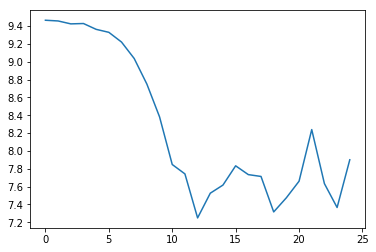

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [49]:
index2word_en = {"SOS": 0, "EOS": 1}

for i, word in enumerate(vocab_en):
    index2word_en[i + 2] = word
    
index2word_zh = {"SOS": 0, "EOS": 1}
for i, word in enumerate(vocab_zh):
    index2word_zh[i + 2] = word

In [53]:
def evaluate(sentence, max_length=MAX_LENGTH):
    print(sentence)
    
    input_variable = Variable(torch.LongTensor(sentence).view(-1, 1))
    input_length = input_variable.size()[0]
    
    if USE_CUDA: input_variable = input_variable.cuda()
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, 1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    s("decoder_attions", decoder_attentions.size())
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        s("decoder_attion", decoder_attention.size())
        decoder_attentions[di,:decoder_attention.size(0)] += decoder_attention.cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(index2word_zh[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [54]:
import random

def evaluate_randomly():
    indices = np.arange(len(np.array(pairs_to_vec)))
    np.random.shuffle(indices)
    pair_vec = pairs_to_vec[indices[0]]
    pair = pairs[indices[0]]
    
    output_words, decoder_attn = evaluate(pair_vec[0], 10)
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [55]:
evaluate_randomly()

[4297, 5673, 3692, 1888]
decoder_attions's size is torch.Size([10, 10])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
decoder_attion's size is torch.Size([4])
> i m not guilty
= 我没有罪
< 我 我 我 的 的 的 的 的 的 的



In [47]:
index2word_zh[1]

KeyError: 1

In [ ]:
# # 对模型进行测试
# encoder_test = EncoderRNN(10, 10, 1)
# decoder_test = AttnDecoderRNN(10, 10, 1)

# print(encoder_test)
# print(decoder_test)

# encoder_hidden = encoder_test.init_hidden()
# word_input = Variable(torch.LongTensor([[1, 9, 3, 4]]))
# print(word_input)
# print(word_input.size())


# if USE_CUDA:
#     encoder_test.cuda()
#     word_input.cuda()

# encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

# word_inputs = Variable(torch.LongTensor([1, 2, 6, 6, 8]))
# # 不是很理解
# decoder_attns = torch.zeros(1, 5, 4)
# decoder_hidden = encoder_hidden 
# decoder_context = Variable(torch.zeros(1, 1, decoder_test.hidden_size))

# if USE_CUDA:
#     decoder_test.cuda()
#     word_inputs = word_inputs.cuda()
#     decoder_context = decoder_context.cuda()
    
# for i in range(5):
#     decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i].view(1, -1), decoder_context, decoder_hidden, encoder_outputs)
#     print(decoder_output)
#     decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

In [95]:
for i in range(2):
    print(i)

0
1


In [56]:
 m = nn.LogSoftmax()

In [38]:
a = Variable(torch.FloatTensor([1,1,1]).view(1, -1).unsqueeze(0))

In [39]:
a.is_cuda

False

In [40]:
a.cuda()

Variable containing:
(0 ,.,.) = 
  1  1  1
[torch.cuda.FloatTensor of size 1x1x3 (GPU 0)]

In [41]:
a.is_cuda

False

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.828 seconds.
Prefix dict has been built succesfully.


RuntimeError: cuda runtime error (30) : unknown error at /pytorch/torch/lib/THC/THCGeneral.c:70